In [600]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

ASK:

Será que é possível indicar cervejas que o usuário vai gostar, sabendo as que ele ja experimentou, assim melhorando sua experiência futura com base em experiências passadas?

GET:

Para sanar essa dúvida precisamos de dados... Para isso, fomos a busca e encontramos algo interessante

No kaggle achamos esse conjunto de dados: https://www.kaggle.com/datasets/rdoume/beerreviews?select=beer_reviews.csv

e a partir dele vamos explorar para buscar entender os dados e como eles podem nos ajudar a modelar a nossa solução

EXPLORE:

In [601]:
df = pd.read_csv('beer_reviews.csv')

In [602]:
df

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586609,14359,The Defiant Brewing Company,1162684892,5.0,4.0,3.5,maddogruss,Pumpkin Ale,4.0,4.0,The Horseman's Ale,5.2,33061
1586610,14359,The Defiant Brewing Company,1161048566,4.0,5.0,2.5,yelterdow,Pumpkin Ale,2.0,4.0,The Horseman's Ale,5.2,33061
1586611,14359,The Defiant Brewing Company,1160702513,4.5,3.5,3.0,TongoRad,Pumpkin Ale,3.5,4.0,The Horseman's Ale,5.2,33061
1586612,14359,The Defiant Brewing Company,1160023044,4.0,4.5,4.5,dherling,Pumpkin Ale,4.5,4.5,The Horseman's Ale,5.2,33061


In [603]:
df.shape

(1586614, 13)

Uau, temos aqui mais de um milhão de registros e também 13 'features' que descrevem nossos dados, mas vamos aqui buscar entender o que são esses dados, de que forma são relevantes para nós, e como podemos manipulálos

Dentro da nossa análise (objetivo de criar um sistema de recomendação), não faz sentido guardarmos dados da cervejaria

In [604]:
df = df.drop(columns=['brewery_id','brewery_name'],axis=1)

Será que existem valores nulos?

In [605]:
nulos_por_coluna = df.isnull().sum()

# Exibir o número de valores nulos por coluna
print("Quantidade de valores nulos por coluna:")
print(nulos_por_coluna)

Quantidade de valores nulos por coluna:
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64


Temos poucos nulos para um dataset de um milhão e meio. Mas para esses nulos no abv, será que conseguimos preencher, caso o abv de uma dessas cervejas ja tenha sido preenchida?

In [606]:
valores_abv_por_id = df.dropna(subset=['beer_abv']).set_index('beer_beerid')['beer_abv'].to_dict()

df['beer_abv'] = df.apply(lambda row: valores_abv_por_id.get(row['beer_beerid'], row['beer_abv']), axis=1)

In [607]:
nulo_abv = df['beer_abv'].isnull().sum()

print(nulo_abv)

67785


A resposta é não rs.

quantas cervejas estão sem essa informação?

In [608]:
unique_beer_ids_with_null_abv = df[df['beer_abv'].isnull()]['beer_beerid'].nunique()
unique_beer_ids_with_null_abv

17043

17 mil cervejas diferentes, acho que é muito para preencher a mão rs

Como estamos trabalhando com um sistema de recomendação, o usuário que avaliou é bastante importante para nós. e já que temos muitos dados, iremos excluir as linhas com nulo nesse campo

In [609]:
df = df.dropna(subset=['review_profilename'])


Dicionário:


Brewery id: é um identificador único atribuído a cada cervejaria listada no conjunto de dados

brewery name: é o nome da cervejaria

Review time: provavelmente se refere ao momento em que uma avaliação ou revisão específica de uma cerveja foi registrada. Porém parece estar codificado.

Review Overall: pontuação geral ou avaliação geral dada a uma cerveja específica por um revisor

Review aroma: Assim como o review overall, é uma coluna subjetiva e trata da nota atribuida ao aroma de cada cerveja.

Review appareance: Subjetiva e trata a respeito da aparência visual

Review profile name: Essa coluna descre o nome de usuario daquele revisor, ou seja para aquela aquela cerveja, com aquelas notas, quem atribuiu.

Beer_Style: categorização do tipo ou estilo específico de cerveja que está sendo avaliada ou descrita. Cada cerveja pode ser classificada em um estilo com base em suas características de sabor, aroma, aparência, ingredientes e outros atributos distintivos. Temos alguns estilos como IPA, PILSEN...

Review taste: pontuação atribuída à sensação na boca de uma cerveja específica por um revisor

Beer name: Nome da cerveja

beer abv: Alcoól por volume

beer id: id de cada cerveja

Com essa descrição e entendimento é natural que surjam algumas dúvidas. Por exemplo, será que essa coluna de review time realmente pode ser convertida?

In [610]:
datas = df['review_time']
datas

0          1234817823
1          1235915097
2          1235916604
3          1234725145
4          1293735206
              ...    
1586609    1162684892
1586610    1161048566
1586611    1160702513
1586612    1160023044
1586613    1160005319
Name: review_time, Length: 1586266, dtype: int64

Para isso, após algumas pesquisas vimos que pode estar em padrão unix. E vamos tentar convertê-las

In [611]:
ndt = []
for data in datas:
    dt_object = datetime.datetime.fromtimestamp(data)
    formatted_date = dt_object.strftime('%Y-%m-%d %H:%M:%S')

    ndt.append(formatted_date)

dt = {'Data review': ndt}
df_dt = pd.DataFrame(dt)

In [612]:
df_dt

,Data review
0,2009-02-16 17:57:03
1,2009-03-01 10:44:57
2,2009-03-01 11:10:04
3,2009-02-15 16:12:25
4,2010-12-30 15:53:26
...,...
1586261,2006-11-04 21:01:32
1586262,2006-10-16 22:29:26
1586263,2006-10-12 22:21:53
1586264,2006-10-05 01:37:24


Uau, então realmente é possivél converter aquela coluna em data, mas deixaremos daquele jeito por enquanto

In [613]:
#Quantas cervejas temos no dataset?

qtd_cervejas = df['beer_beerid'].nunique()
print(qtd_cervejas)

66051


Não sabia que existiam tantas cervejas assim rs

Para as outras colunas de review, sabemos que são subjetivas, mas para cada uma delas, qual será que é o intervalo

In [614]:
review_colunms = ['review_overall','review_aroma', 'review_appearance', 'review_palate', 'review_taste' ]

In [615]:
for c in review_colunms:
    print(c, df[c].min(), ' - ',df[c].max())

review_overall 0.0  -  5.0
review_aroma 1.0  -  5.0
review_appearance 0.0  -  5.0
review_palate 1.0  -  5.0
review_taste 1.0  -  5.0


Parece que estão estabelecidos valores de 0 a 5 para todas colunas, embora sejam subjetivas, temos intervalos bem definidos

Como será que essas notas se distribuem para cada review? Será que temos uma distribuição normal das coisas, ou temos a maioria das cervejas proximas de 5 e vice-versa?

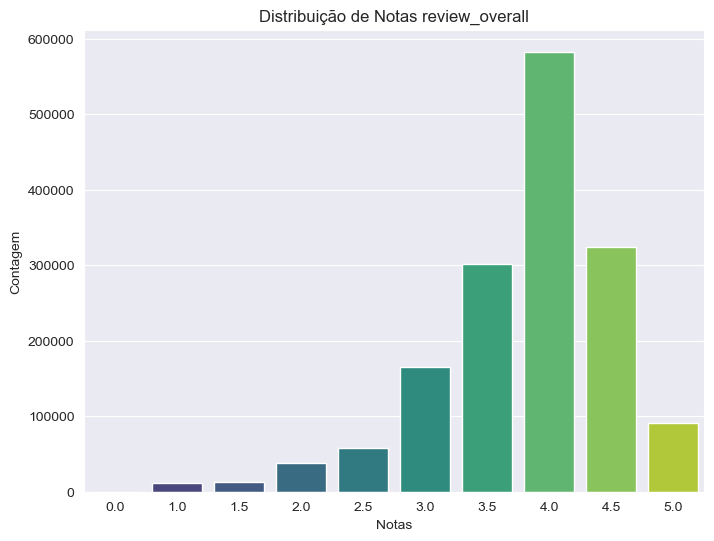

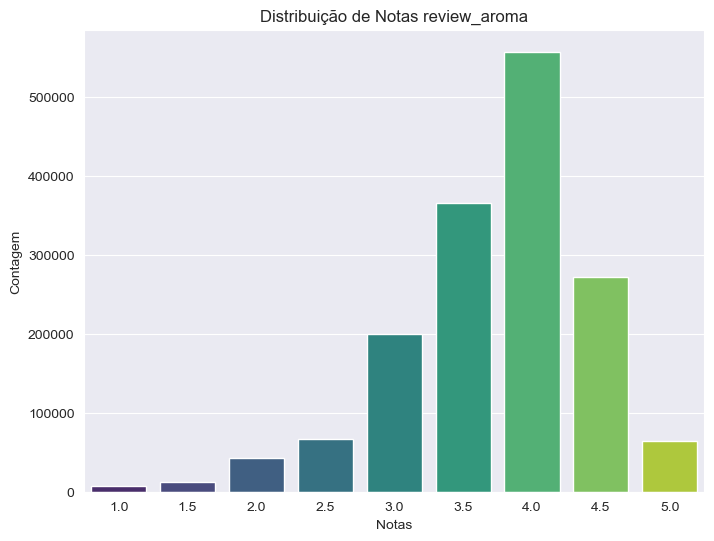

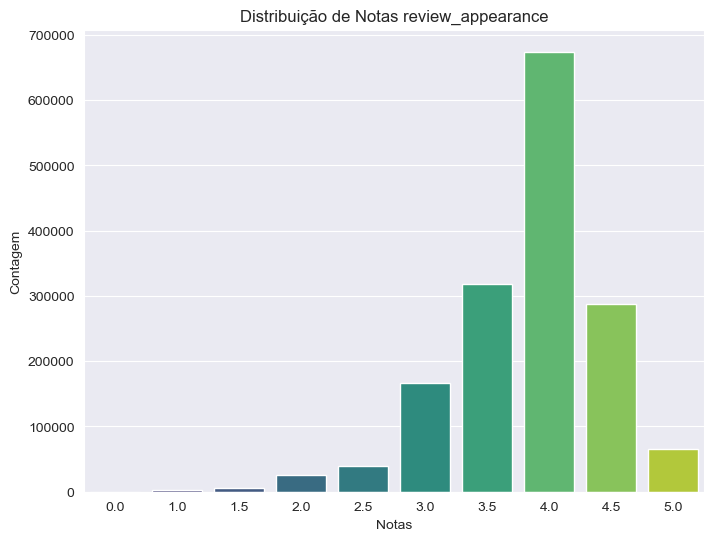

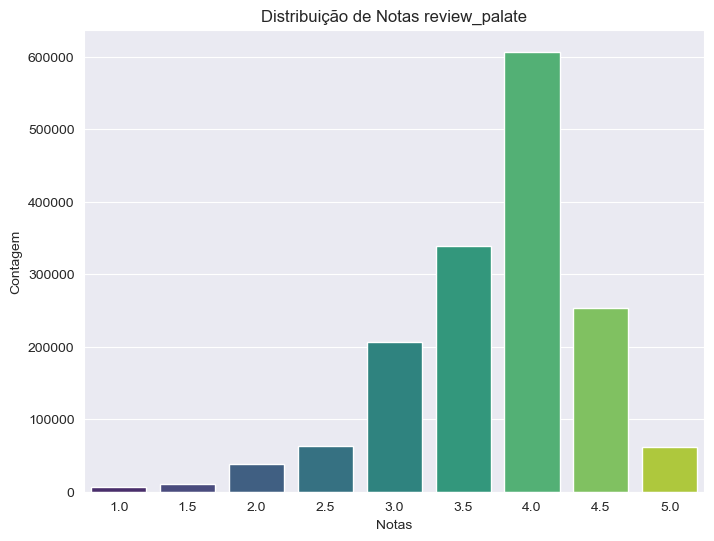

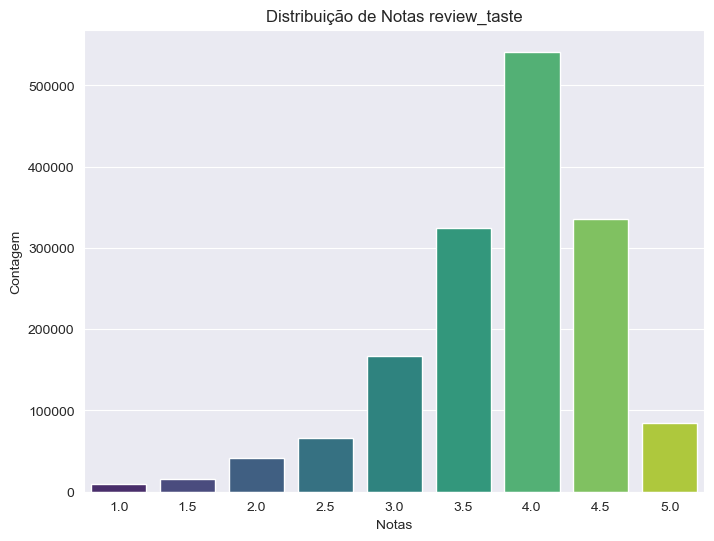

In [616]:
for c in review_colunms:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=df[c], palette="viridis")

    # Adicionar título e rótulos dos eixos
    plt.title(f"Distribuição de Notas {c}")
    plt.xlabel("Notas")
    plt.ylabel("Contagem")

    # Exibir o gráfico
    plt.show()

In [617]:
for c in review_colunms:
    print(df[c].mean(), df[c].median())

3.8156280220341356 4.0
3.735685565976955 4.0
3.84167125816225 4.0
3.7437532544982997 4.0
3.7929209224682365 4.0


Vemos aqui, que predominantemente temos os dados 'ao redor' do valor 4.

Será que mesmo para valores tão proximos, temos a notas baixas como "outliers"?

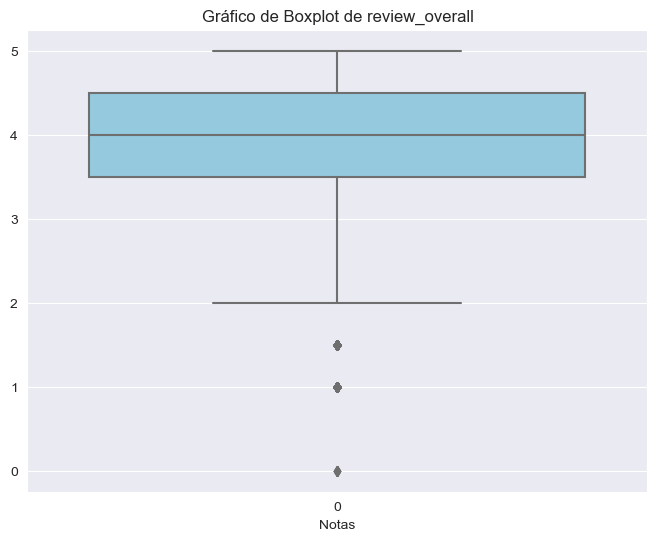

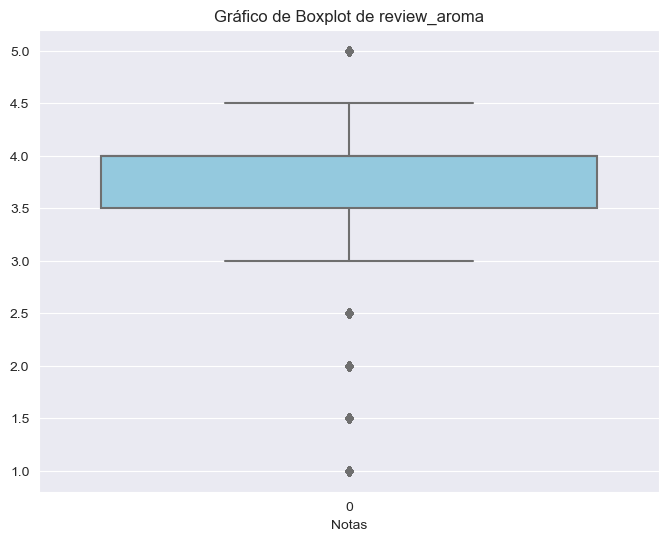

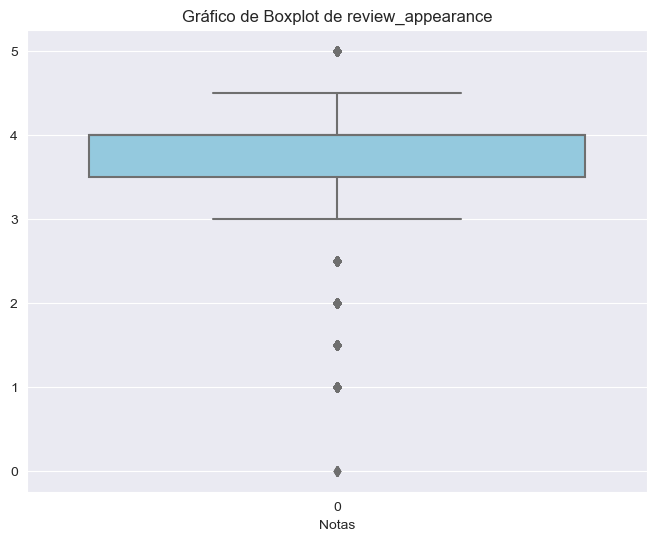

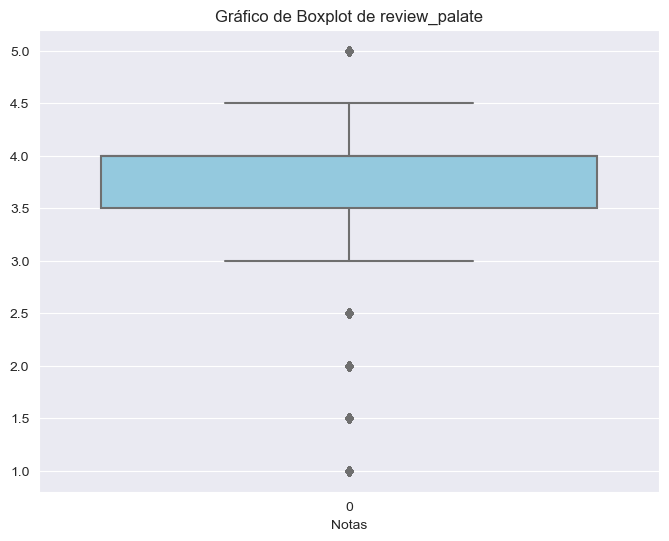

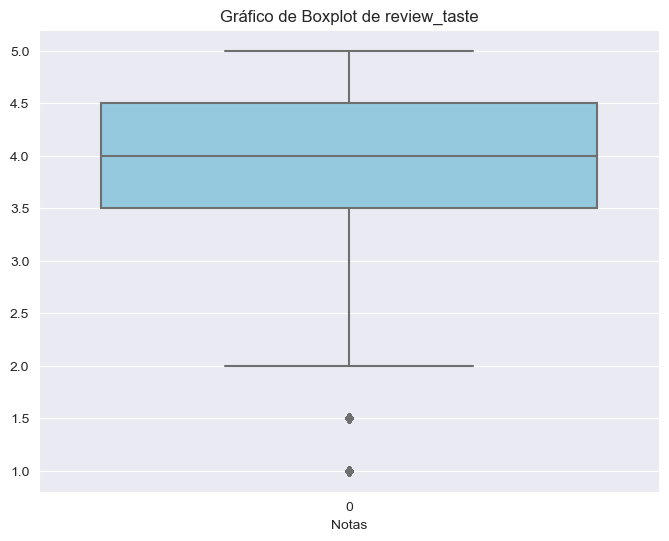

In [618]:
for c in review_colunms:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df[c], color='skyblue')

    # Adicionar título e rótulo do eixo x
    plt.title(f"Gráfico de Boxplot de {c}")
    plt.xlabel("Notas")

    # Exibir o gráfico
    plt.show()

Uau, com esses gráficos conseguimos ver que algumas notas, mesmo que dentro do domínio do problema são consideradas anomalias

O estilo de cerveja pode nos trazer algumas informações interessantes não contidas no dataset. Vamos analisar

In [619]:
df['beer_style'].nunique()

104

In [620]:
estilos_unicos = df['beer_style'].unique()

# Exibir a lista de estilos de cerveja únicos
for estilo in estilos_unicos:
    print(estilo)

Hefeweizen
English Strong Ale
Foreign / Export Stout
German Pilsener
American Double / Imperial IPA
Herbed / Spiced Beer
Light Lager
Oatmeal Stout
American Pale Lager
Rauchbier
American Pale Ale (APA)
American Porter
Belgian Strong Dark Ale
American IPA
American Stout
Russian Imperial Stout
American Amber / Red Ale
American Strong Ale
Märzen / Oktoberfest
American Adjunct Lager
American Blonde Ale
Euro Pale Lager
English Brown Ale
Scotch Ale / Wee Heavy
Fruit / Vegetable Beer
American Double / Imperial Stout
Belgian Pale Ale
English Bitter
English Porter
Irish Dry Stout
American Barleywine
Belgian Strong Pale Ale
Doppelbock
Maibock / Helles Bock
Pumpkin Ale
Dortmunder / Export Lager
Euro Strong Lager
Euro Dark Lager
Low Alcohol Beer
Weizenbock
Extra Special / Strong Bitter (ESB)
Bock
English India Pale Ale (IPA)
Altbier
Kölsch
Munich Dunkel Lager
Rye Beer
American Pale Wheat Ale
Milk / Sweet Stout
Schwarzbier
Vienna Lager
American Amber / Red Lager
Scottish Ale
Witbier
American Black A

Vamos carregar um dataset com o estilo e uma taxa de ibu (indicador de amargor)

In [621]:
estilos = pd.read_csv('saida.csv')
estilos

,beer_style,ibu_min,ibu_max
0,Altbier,25.0,50.0
1,Amber Kellerbier,25.0,40.0
2,American Amber Ale,25.0,40.0
3,American Barleywine,50.0,100.0
4,American Brown Ale,20.0,30.0
...,...,...,...
192,Berliner Weissbier,7.0,7.0
193,Kvass,12.0,12.0
194,Faro,10.0,10.0
195,Happoshu,11.0,11.0


In [622]:
valores_df1 = df['beer_style'].unique()

# Obter os valores únicos da coluna 'coluna_igual' no segundo DataFrame
valores_df2 = estilos['beer_style'].unique()

# Identificar quais valores estão em valores_df1 e não estão em valores_df2
valores_nao_em_df2 = [valor for valor in valores_df1 if valor not in valores_df2]
print(len(valores_nao_em_df2))
for valor in valores_nao_em_df2:
    print(valor)

0


Bom ressaltar que inicialmente esse número não era 0, foi feito uma coleta de dados para que podessemos saber o ibu de cada cerveja. Agora vamos inserir essas informações no dataset

In [623]:
df = pd.merge(df, estilos, on='beer_style')

df

,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,ibu_min,ibu_max
0,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986,10.0,15.0
1,1224350360,4.0,4.0,3.0,Likeburning,Hefeweizen,4.0,3.5,Hefeweizen,5.0,20575,10.0,15.0
2,1316545215,4.0,3.5,3.0,JamesS,Hefeweizen,4.0,4.5,Hefe Weizen,4.5,73291,10.0,15.0
3,1133896338,3.5,3.5,3.0,GusterFan,Hefeweizen,3.0,3.5,Wheezy Heifer,5.5,27229,10.0,15.0
4,1193191936,4.0,4.0,3.5,harpo111,Hefeweizen,3.5,3.5,Hefe-Weizen,5.5,2776,10.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586261,1288562807,4.5,4.0,4.0,MasterSki,Bière de Champagne / Bière Brut,4.5,4.0,Dominus Vobiscum Brut,11.0,59014,40.0,40.0
1586262,1288546131,4.0,4.0,3.5,jrallen34,Bière de Champagne / Bière Brut,4.5,4.0,Dominus Vobiscum Brut,11.0,59014,40.0,40.0
1586263,1281632126,4.0,4.0,5.0,Phyl21ca,Bière de Champagne / Bière Brut,4.0,4.0,Dominus Vobiscum Brut,11.0,59014,40.0,40.0
1586264,1279650183,5.0,4.0,4.5,wordemupg,Bière de Champagne / Bière Brut,4.5,4.5,Dominus Vobiscum Brut,11.0,59014,40.0,40.0


Contudo, não é muito bom trabalharmos com esses intervalos, por isso, vamos trazer como um valor único, sendo a média entre ambos.

In [624]:
df['mean ibu'] = (df['ibu_min'] + df['ibu_max'])/2

In [625]:
df = df.drop(columns=['ibu_min', 'ibu_max'],axis=1)

Será que temos variáveis muito correlacionadas? Ou seja, será que temos variáveis que são explicadas por outras?

In [626]:
df_c = ['beer_abv','mean ibu']
df_c.extend(review_colunms)

df_cc = df[df_c]

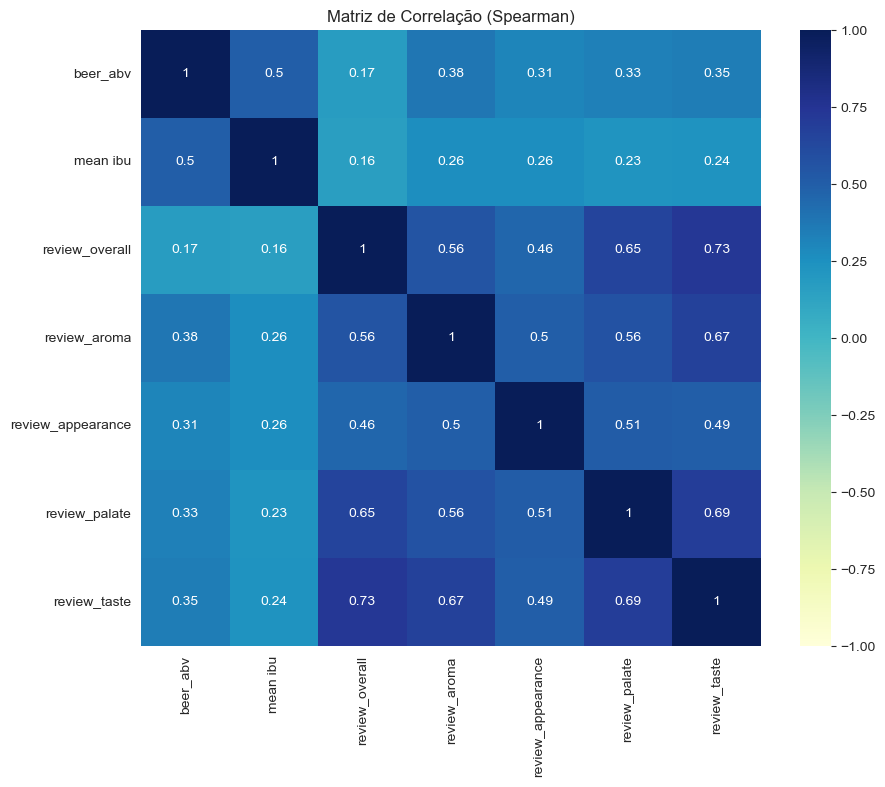

In [627]:
correlation_matrix = df_cc.corr(method='spearman')

# Plotando a matriz de correlação como um heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', vmin=-1, vmax=1)
plt.title('Matriz de Correlação (Spearman)')
plt.show()

Essa matriz de correlação nos traz algumas coisas interessantes como, por exemplo, conseguimos ver quais são os fatores que mais influência na nota final dada a uma cerveja. Vemos aqui, por exemplo, que a nota dada para o sabor tem uma influencia direta na nota final da cerveja. Já a aparência tem certa influência, mas não tanta.

vemos também que não faz sentido para nossa análise levar em consideração a data que o review foi feito

In [628]:
df = df.drop(columns=['review_time'],axis=1)

In [629]:
df

,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,mean ibu
0,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986,12.5
1,4.0,4.0,3.0,Likeburning,Hefeweizen,4.0,3.5,Hefeweizen,5.0,20575,12.5
2,4.0,3.5,3.0,JamesS,Hefeweizen,4.0,4.5,Hefe Weizen,4.5,73291,12.5
3,3.5,3.5,3.0,GusterFan,Hefeweizen,3.0,3.5,Wheezy Heifer,5.5,27229,12.5
4,4.0,4.0,3.5,harpo111,Hefeweizen,3.5,3.5,Hefe-Weizen,5.5,2776,12.5
...,...,...,...,...,...,...,...,...,...,...,...
1586261,4.5,4.0,4.0,MasterSki,Bière de Champagne / Bière Brut,4.5,4.0,Dominus Vobiscum Brut,11.0,59014,40.0
1586262,4.0,4.0,3.5,jrallen34,Bière de Champagne / Bière Brut,4.5,4.0,Dominus Vobiscum Brut,11.0,59014,40.0
1586263,4.0,4.0,5.0,Phyl21ca,Bière de Champagne / Bière Brut,4.0,4.0,Dominus Vobiscum Brut,11.0,59014,40.0
1586264,5.0,4.0,4.5,wordemupg,Bière de Champagne / Bière Brut,4.5,4.5,Dominus Vobiscum Brut,11.0,59014,40.0


In [630]:
beerid_counts = df['beer_beerid'].value_counts().reset_index()
beerid_counts.columns = ['beer_beerid', 'count']
beerid_counts

,beer_beerid,count
0,2093,3289
1,412,3110
2,1904,2999
3,1093,2727
4,92,2702
...,...,...
66046,59983,1
66047,40239,1
66048,72871,1
66049,56688,1


In [631]:
beerid_counts['count'].describe()

count    66051.000000
mean        24.015776
std        110.838706
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max       3289.000000
Name: count, dtype: float64

In [632]:
profile_counts = df['review_profilename'].value_counts().reset_index()
beerid_counts.columns = ['review_profilename', 'count']

In [633]:
profile_counts

,index,review_profilename
0,northyorksammy,5817
1,BuckeyeNation,4661
2,mikesgroove,4617
3,Thorpe429,3518
4,womencantsail,3497
...,...,...
33382,adam7475,1
33383,BayouBreweryRob,1
33384,Calchas,1
33385,JustinL,1


In [634]:
profile_counts['review_profilename'].describe()

count    33387.000000
mean        47.511487
std        182.599759
min          1.000000
25%          1.000000
50%          3.000000
75%         16.000000
max       5817.000000
Name: review_profilename, dtype: float64

Aqui vemos um pequeno problema, temos cervejas que foram avaliadas muito poucas vezes, assim como temos usuarios que avaliaram muito pouco. Opiniões de usuários que avaliaram apenas algumas vezes podem não ser tão confiáveis quanto as de usuários que avaliaram mais vezes. Da mesma forma, cervejas avaliadas poucas vezes podem ter avaliações menos consistentes e informativas. Avaliações com baixas ocorrências podem afetar análises estatísticas e modelagem. Modelos de recomendação, por exemplo, podem ter dificuldade em encontrar padrões significativos em avaliações escassas. Por isso, vamos excluir os usuarios que avaliaram pouco e as cervejas que foram pouco avaliadas



In [635]:
beerid_counts = df['beer_beerid'].value_counts()
profilename_counts = df['review_profilename'].value_counts()

# Filtrando cervejas com menos de 20 avaliações e usuários com menos de 10 avaliações
beerids_to_keep = beerid_counts[beerid_counts >= 25].index
profilenames_to_keep = profilename_counts[profilename_counts >= 15].index

"Perdemos" 20 mil dados no caminho

MODEL

Vamos iniciar com uma abordagem de filtragem demográfica, tirando a nota média de cada cerveja, e adicionando quantas vezes cada cerveja aparece, ou seja, foi avaliada.

In [636]:
df = df[df['beer_beerid'].isin(beerids_to_keep) & df['review_profilename'].isin(profilenames_to_keep)]
dem = df.drop_duplicates(subset=['beer_beerid'])
dem['beer_vote_count'] = df.groupby('beer_beerid')['beer_beerid'].transform('count')

C:\Users\Artur\AppData\Local\Temp\ipykernel_14096\456656070.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dem['beer_vote_count'] = df.groupby('beer_beerid')['beer_beerid'].transform('count')


In [637]:
df

,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,mean ibu
1,4.0,4.0,3.0,Likeburning,Hefeweizen,4.0,3.5,Hefeweizen,5.0,20575,12.5
26,3.5,3.5,3.0,superspak,Hefeweizen,4.0,4.0,Wild Frog Wheat Ale,6.0,36862,12.5
28,4.0,4.0,3.0,Viciousknishs,Hefeweizen,3.5,3.5,Wild Frog Wheat Ale,6.0,36862,12.5
29,3.5,3.5,4.0,sixerofelixir,Hefeweizen,4.0,4.0,Wild Frog Wheat Ale,6.0,36862,12.5
30,4.0,4.0,4.5,Trystero,Hefeweizen,4.5,4.0,Wild Frog Wheat Ale,6.0,36862,12.5
...,...,...,...,...,...,...,...,...,...,...,...
1586242,4.0,4.0,4.5,clickpush,Bière de Champagne / Bière Brut,2.5,3.5,Krait Prestige,8.0,33766,40.0
1586243,2.0,3.0,3.0,blitheringidiot,Bière de Champagne / Bière Brut,3.0,3.0,Krait Prestige,8.0,33766,40.0
1586244,4.0,3.5,3.5,IntriqKen,Bière de Champagne / Bière Brut,4.0,4.5,Krait Prestige,8.0,33766,40.0
1586245,4.0,3.5,4.0,Ego,Bière de Champagne / Bière Brut,4.0,3.5,Krait Prestige,8.0,33766,40.0


In [638]:
user_avg_scores = df.groupby('review_profilename')['review_overall'].mean()

# Criar uma nova coluna 'avg_user_score' no DataFrame original
df['avg_user_score'] = df['review_profilename'].map(user_avg_scores)

C:\Users\Artur\AppData\Local\Temp\ipykernel_14096\1781497202.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_user_score'] = df['review_profilename'].map(user_avg_scores)


In [639]:
df

,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,mean ibu,avg_user_score
1,4.0,4.0,3.0,Likeburning,Hefeweizen,4.0,3.5,Hefeweizen,5.0,20575,12.5,3.423077
26,3.5,3.5,3.0,superspak,Hefeweizen,4.0,4.0,Wild Frog Wheat Ale,6.0,36862,12.5,4.038012
28,4.0,4.0,3.0,Viciousknishs,Hefeweizen,3.5,3.5,Wild Frog Wheat Ale,6.0,36862,12.5,3.966258
29,3.5,3.5,4.0,sixerofelixir,Hefeweizen,4.0,4.0,Wild Frog Wheat Ale,6.0,36862,12.5,3.663380
30,4.0,4.0,4.5,Trystero,Hefeweizen,4.5,4.0,Wild Frog Wheat Ale,6.0,36862,12.5,4.240000
...,...,...,...,...,...,...,...,...,...,...,...,...
1586242,4.0,4.0,4.5,clickpush,Bière de Champagne / Bière Brut,2.5,3.5,Krait Prestige,8.0,33766,40.0,3.824232
1586243,2.0,3.0,3.0,blitheringidiot,Bière de Champagne / Bière Brut,3.0,3.0,Krait Prestige,8.0,33766,40.0,3.669089
1586244,4.0,3.5,3.5,IntriqKen,Bière de Champagne / Bière Brut,4.0,4.5,Krait Prestige,8.0,33766,40.0,3.955544
1586245,4.0,3.5,4.0,Ego,Bière de Champagne / Bière Brut,4.0,3.5,Krait Prestige,8.0,33766,40.0,3.893557


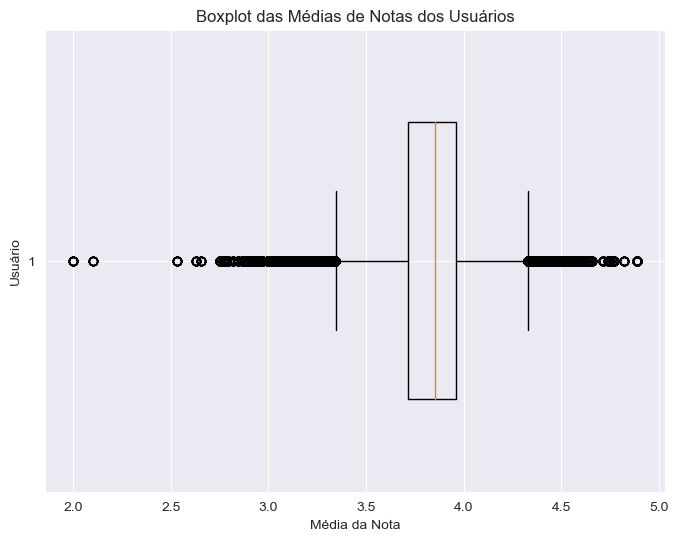

In [640]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['avg_user_score'], vert=False, widths=0.6, showfliers=True)

plt.title('Boxplot das Médias de Notas dos Usuários')
plt.xlabel('Média da Nota')
plt.ylabel('Usuário')

plt.show()

In [641]:
Q1 = df['avg_user_score'].quantile(0.25)
Q3 = df['avg_user_score'].quantile(0.75)
IQR = Q3 - Q1

# Definir limites para identificar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar outliers
outliers = df[(df['avg_user_score'] < lower_bound) | (df['avg_user_score'] > upper_bound)]

outliers

,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,mean ibu,avg_user_score
58,4.0,3.5,3.5,nick76,Hefeweizen,3.0,4.0,Wild Frog Wheat Ale,6.0,36862,12.5,3.318501
82,3.5,3.5,4.0,JDV,Hefeweizen,3.0,3.5,Wild Frog Wheat Ale,6.0,36862,12.5,3.332474
143,2.0,3.0,3.5,Arbitrator,Hefeweizen,2.0,3.0,Kirkland Signature Hefeweizen,5.5,48519,12.5,3.043307
194,3.5,3.5,3.5,newcastleme,Hefeweizen,4.0,3.5,Hefeweizen,5.0,20575,12.5,3.080000
195,4.0,3.5,4.0,newcastleme,Hefeweizen,3.5,4.0,Hefeweizen,5.0,20575,12.5,3.080000
...,...,...,...,...,...,...,...,...,...,...,...,...
1586028,3.0,3.5,2.0,JDV,Bière de Champagne / Bière Brut,2.0,3.0,Malheur Bière Brut (Brut Reserve),12.0,5818,40.0,3.332474
1586065,3.5,3.5,3.5,rastaman,Bière de Champagne / Bière Brut,3.5,3.5,Malheur Bière Brut (Brut Reserve),12.0,5818,40.0,3.131579
1586074,3.5,3.5,4.0,kojevergas,Bière de Champagne / Bière Brut,3.5,4.0,Malheur Brut Noir (Black Chocolate),12.0,16487,40.0,3.010606
1586162,2.0,3.0,1.0,flyingpig,Bière de Champagne / Bière Brut,2.0,2.5,Kasteel Cru,5.2,26652,40.0,3.267241


In [642]:
df = df[(df['avg_user_score'] >= lower_bound) & (df['avg_user_score'] <= upper_bound)]

In [643]:
df

,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,mean ibu,avg_user_score
1,4.0,4.0,3.0,Likeburning,Hefeweizen,4.0,3.5,Hefeweizen,5.0,20575,12.5,3.423077
26,3.5,3.5,3.0,superspak,Hefeweizen,4.0,4.0,Wild Frog Wheat Ale,6.0,36862,12.5,4.038012
28,4.0,4.0,3.0,Viciousknishs,Hefeweizen,3.5,3.5,Wild Frog Wheat Ale,6.0,36862,12.5,3.966258
29,3.5,3.5,4.0,sixerofelixir,Hefeweizen,4.0,4.0,Wild Frog Wheat Ale,6.0,36862,12.5,3.663380
30,4.0,4.0,4.5,Trystero,Hefeweizen,4.5,4.0,Wild Frog Wheat Ale,6.0,36862,12.5,4.240000
...,...,...,...,...,...,...,...,...,...,...,...,...
1586242,4.0,4.0,4.5,clickpush,Bière de Champagne / Bière Brut,2.5,3.5,Krait Prestige,8.0,33766,40.0,3.824232
1586243,2.0,3.0,3.0,blitheringidiot,Bière de Champagne / Bière Brut,3.0,3.0,Krait Prestige,8.0,33766,40.0,3.669089
1586244,4.0,3.5,3.5,IntriqKen,Bière de Champagne / Bière Brut,4.0,4.5,Krait Prestige,8.0,33766,40.0,3.955544
1586245,4.0,3.5,4.0,Ego,Bière de Champagne / Bière Brut,4.0,3.5,Krait Prestige,8.0,33766,40.0,3.893557


In [644]:
beerid_avg_review = df.groupby('beer_beerid')['review_overall'].mean().reset_index()

# Renomeando a coluna para refletir a média
beerid_avg_review.rename(columns={'review_overall': 'avg_beer_score'}, inplace=True)

In [645]:
beerid_avg_review

,beer_beerid,avg_beer_score
0,5,3.544737
1,6,3.700127
2,7,3.252577
3,8,3.617188
4,9,3.409524
...,...,...
8035,76144,4.140000
8036,76323,4.000000
8037,76525,4.019608
8038,76571,3.722222


In [646]:
dem = pd.merge(beerid_avg_review,dem, on='beer_beerid',how='inner')

In [647]:
dem

,beer_beerid,avg_beer_score,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,mean ibu,beer_vote_count
0,5,3.544737,4.0,3.5,3.5,Backer2004,Vienna Lager,3.5,4.0,Amber,4.5,24.0,402
1,6,3.700127,4.0,3.5,4.0,Strix,English Brown Ale,3.5,3.5,Turbodog,5.6,20.0,820
2,7,3.252577,3.5,3.0,3.0,matty,Fruit / Vegetable Beer,3.5,3.0,Purple Haze,4.2,20.0,611
3,8,3.617188,3.5,2.5,3.5,optimator13,American Adjunct Lager,4.0,3.0,Wheat,4.2,12.0,65
4,9,3.409524,2.5,2.0,2.0,walleye,American Pale Lager,2.0,2.0,Golden,4.2,30.0,113
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8035,76144,4.140000,4.0,4.0,4.0,SHODriver,American Strong Ale,4.0,4.5,He'Brew Jewbelation Fifteen,15.0,75.0,50
8036,76323,4.000000,4.5,4.0,4.5,pmlondrigan,Belgian Pale Ale,3.5,4.5,Rayon Vert,7.0,25.0,24
8037,76525,4.019608,4.5,5.0,4.5,seanwhite,American IPA,4.0,4.0,The Alchemist / Ninkasi / Stone - More Brown T...,7.4,55.0,52
8038,76571,3.722222,4.0,4.0,4.5,Luigi,Munich Helles Lager,4.5,4.0,Samuel Adams Alpine Spring,5.8,19.0,28



Podemos usar as avaliações médias das cervejas como pontuação, mas usar isso não será justo, pois uma cerveja com classificação média de 4.5 e apenas 3 votos não pode ser considerado melhor do que o filme com classificação média de 4, mas 40 votos. Portanto, usarei a classificação ponderada (wr)

In [648]:
C= df['review_overall'].mean()
C

3.844084185896594

Portanto, a classificação média para todas as cervejas é de aproximadamente 3.8 em uma escala de 10. O próximo passo é determinar um valor apropriado para m, os votos mínimos necessários para serem listados no gráfico. Usaremos o percentil 90 como ponto de corte. Em outras palavras, para que uma cerveja apareça nas paradas, ele deve ter mais votos do que pelo menos 80% dos filmes da lista.

In [649]:
m= dem['beer_vote_count'].quantile(0.8)
m

208.0

In [650]:
q_beers = dem.copy().loc[dem['beer_vote_count'] >= m]
q_beers.shape

(1615, 13)

Vemos que existem 1837 cervejas que se qualificam para estar nesta lista. Agora, precisamos calcular nossa métrica para cada cerveja qualificada. Para fazer isso, vamos definir uma função, weighted_rating() e definir uma nova pontuação de recurso, da qual calcularemos o valor aplicando essa função ao nosso DataFrame de cervejas qualificados

In [651]:
def weighted_rating(x, m=m, C=C):
    v = x['beer_vote_count']
    R = x['avg_beer_score']
    
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [652]:
q_beers['score'] = q_beers.apply(weighted_rating, axis=1)

In [653]:
q_beers = q_beers.sort_values('score', ascending=False)

In [654]:
q_beers[['beer_name','beer_style', 'beer_vote_count', 'avg_beer_score', 'score']].head(10)

,beer_name,beer_style,beer_vote_count,avg_beer_score,score
2564,Pliny The Elder,American Double / Imperial IPA,2164,4.580907,4.516295
845,Trappist Westvleteren 12,Quadrupel (Quad),1136,4.605621,4.487764
420,Weihenstephaner Hefeweissbier,Hefeweizen,1806,4.507118,4.438642
6192,Founders CBS Imperial Stout,American Double / Imperial Stout,578,4.570018,4.377913
3733,Pliny The Younger,American Double / Imperial IPA,529,4.577148,4.370259
3339,Heady Topper,American Double / Imperial IPA,425,4.623487,4.367380
4758,The Abyss,American Double / Imperial Stout,1259,4.439195,4.354816
502,Trappist Westvleteren 8,Dubbel,678,4.509188,4.353047
4350,Sculpin India Pale Ale,American IPA,1249,4.427459,4.344177
3264,Tröegs Nugget Nectar,American Amber / Red Ale,1786,4.385960,4.329435


Uhu, aqui temos nossa primeira forma de recomendação, mas note que esta forma é algo "Geral", Ou seja, não capta os gostos individuais de cada cliente.
Para isso, vamos brincar com a filtragem colaborativa.

FILTRAGEM COLABORATIVA

In [539]:
from surprise import Reader , Dataset, SVD
#from surprise import evaluate

Ops, problema, aqui não achamoso modeulo evaluate, mas com uma breve busca vemos que ele virou cross_validate

In [540]:
from surprise.model_selection import cross_validate

In [541]:
reader = Reader()
ratings = df[['review_profilename','beer_beerid','review_overall']]

In [542]:
ratings

,review_profilename,beer_beerid,review_overall
1,Likeburning,20575,4.0
26,superspak,36862,3.5
28,Viciousknishs,36862,4.0
29,sixerofelixir,36862,3.5
30,Trystero,36862,4.0
...,...,...,...
1586242,clickpush,33766,4.0
1586243,blitheringidiot,33766,2.0
1586244,IntriqKen,33766,4.0
1586245,Ego,33766,4.0


Com base na distribuição plotada vamos categorizar nossos dados em 3 classes, bom médio e ruim, onde vamos normalizar com 0, 1 e 2

In [543]:
'''def map_review(value):
    if value <= 3:
        return 0
    elif 3 < value < 4.5:
        return 1
    else:
        return 2'''

'def map_review(value):\n    if value <= 3:\n        return 0\n    elif 3 < value < 4.5:\n        return 1\n    else:\n        return 2'

In [544]:
'''ratings['review_mapped'] = df['review_overall'].apply(map_review)
ratings = ratings.drop(columns=['review_overall'])'''

"ratings['review_mapped'] = df['review_overall'].apply(map_review)\nratings = ratings.drop(columns=['review_overall'])"

In [545]:
ratings

,review_profilename,beer_beerid,review_overall
1,Likeburning,20575,4.0
26,superspak,36862,3.5
28,Viciousknishs,36862,4.0
29,sixerofelixir,36862,3.5
30,Trystero,36862,4.0
...,...,...,...
1586242,clickpush,33766,4.0
1586243,blitheringidiot,33766,2.0
1586244,IntriqKen,33766,4.0
1586245,Ego,33766,4.0


----------------------------------

In [546]:
data = Dataset.load_from_df(ratings[['review_profilename','beer_beerid','review_overall']], reader)

In [547]:
from surprise.model_selection import KFold

svd = SVD()
kf = KFold(n_splits=5)
kf.split(data)
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([0.57909387, 0.57848773, 0.5779633 , 0.57742819, 0.57943579]),
 'test_mae': array([0.43446866, 0.43302358, 0.43275283, 0.43237768, 0.43469197]),
 'fit_time': (45.83100366592407,
  46.21909499168396,
  46.31190061569214,
  46.361241817474365,
  46.178187131881714),
 'test_time': (1.4270002841949463,
  1.3860211372375488,
  1.357999563217163,
  1.3489997386932373,
  1.364992618560791)}

In [548]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [549]:
ratings[ratings['review_profilename'] == 'Strix']

,review_profilename,beer_beerid,review_overall
844,Strix,48434,4.0
2029,Strix,772,2.5
3116,Strix,82,4.0
7511,Strix,37586,4.0
7847,Strix,47539,4.0
...,...,...,...
1564895,Strix,1708,5.0
1571300,Strix,1934,4.0
1572127,Strix,28944,4.5
1575916,Strix,35720,2.5


In [550]:
svd.predict('Strix', 26432)

Prediction(uid='Strix', iid=26432, r_ui=None, est=3.5382359363939693, details={'was_impossible': False})

Desse jeito ainda não conseguimos recomendar, apenas mostrar o resultado de previsão para um usuário já conhecido

In [655]:
df

,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,mean ibu,avg_user_score
1,4.0,4.0,3.0,Likeburning,Hefeweizen,4.0,3.5,Hefeweizen,5.0,20575,12.5,3.423077
26,3.5,3.5,3.0,superspak,Hefeweizen,4.0,4.0,Wild Frog Wheat Ale,6.0,36862,12.5,4.038012
28,4.0,4.0,3.0,Viciousknishs,Hefeweizen,3.5,3.5,Wild Frog Wheat Ale,6.0,36862,12.5,3.966258
29,3.5,3.5,4.0,sixerofelixir,Hefeweizen,4.0,4.0,Wild Frog Wheat Ale,6.0,36862,12.5,3.663380
30,4.0,4.0,4.5,Trystero,Hefeweizen,4.5,4.0,Wild Frog Wheat Ale,6.0,36862,12.5,4.240000
...,...,...,...,...,...,...,...,...,...,...,...,...
1586242,4.0,4.0,4.5,clickpush,Bière de Champagne / Bière Brut,2.5,3.5,Krait Prestige,8.0,33766,40.0,3.824232
1586243,2.0,3.0,3.0,blitheringidiot,Bière de Champagne / Bière Brut,3.0,3.0,Krait Prestige,8.0,33766,40.0,3.669089
1586244,4.0,3.5,3.5,IntriqKen,Bière de Champagne / Bière Brut,4.0,4.5,Krait Prestige,8.0,33766,40.0,3.955544
1586245,4.0,3.5,4.0,Ego,Bière de Champagne / Bière Brut,4.0,3.5,Krait Prestige,8.0,33766,40.0,3.893557


Text(0.5, 1.0, 'Distribution of Average User Scores')

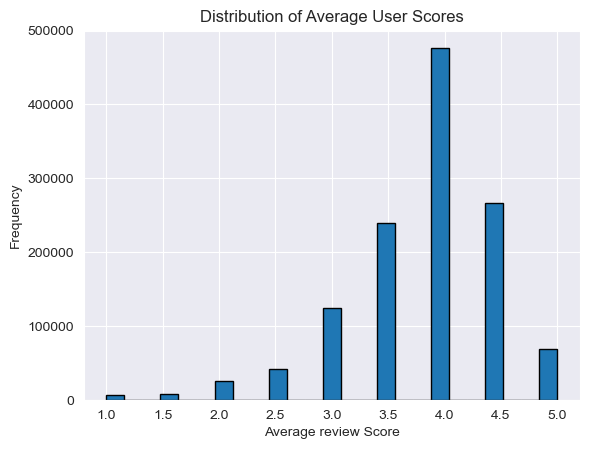

In [656]:
plt.hist(df['review_overall'], bins=25, edgecolor='black')

# Adicione rótulos e título ao gráfico
plt.xlabel('Average review Score')
plt.ylabel('Frequency')
plt.title('Distribution of Average User Scores')

Uau, o comportamento dos usuários é muito "proximo", como será que vamos captar esses gostos pessoais

0 a 3
3.5 a 4.5
4.6 a 5


In [657]:
n12 = df.loc[df['review_overall']<3]
n3 = df.loc[df['review_overall'] == 3]
n35 = df.loc[df['review_overall'] == 3.5]
n4 = df.loc[df['review_overall'] == 4]
n45 = df.loc[df['review_overall'] == 4.5]
n5 = df.loc[df['review_overall'] == 5]

In [658]:
n12.shape

(81913, 12)

In [659]:
n3.shape

(124068, 12)

In [660]:
n35.shape

(239007, 12)

In [661]:
n4.shape

(476920, 12)

In [662]:
n45.shape

(265918, 12)

In [663]:
n5.shape

(68679, 12)

In [664]:
n35 = n35.sample(n=132000, random_state=42)
n4 = n4.sample(n=145000, random_state=42)
n45 = n45.sample(n=135000, random_state=42)

In [665]:
print(n12.shape,n3.shape,
n35.shape,
n4.shape,
n45.shape,
n5.shape)

(81913, 12) (124068, 12) (132000, 12) (145000, 12) (135000, 12) (68679, 12)


Parece que nossas classes estão mais balanceadas agora, porém perdemos quase um milhão de dados no processo

In [666]:
dataframes = [n12, n3, n35, n4, n45, n5]

# Crie um DataFrame vazio com o mesmo esquema
df2 = pd.DataFrame(columns=dataframes[0].columns)

# Adicione os DataFrames ao DataFrame combinado (df2)
for df in dataframes:
    df2 = df2.append(df, ignore_index=True)

C:\Users\Artur\AppData\Local\Temp\ipykernel_14096\1420787094.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(df, ignore_index=True)


In [667]:
df2

,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,mean ibu,avg_user_score
0,2.5,4.5,2.5,JamnesCameron,Hefeweizen,2.5,2.5,Wild Frog Wheat Ale,6.0,36862,12.5,3.968675
1,2.0,2.0,2.0,jsh420,Hefeweizen,2.0,2.0,Wild Frog Wheat Ale,6.0,36862,12.5,3.678862
2,2.5,4.0,3.5,GatorBeerNerd,Hefeweizen,3.0,3.5,Wild Frog Wheat Ale,6.0,36862,12.5,3.984914
3,2.5,3.5,3.5,AltBock,Hefeweizen,2.5,3.0,Wild Frog Wheat Ale,6.0,36862,12.5,3.635234
4,2.5,3.0,3.0,bluejacket74,Hefeweizen,3.5,2.5,Wild Frog Wheat Ale,6.0,36862,12.5,3.874805
...,...,...,...,...,...,...,...,...,...,...,...,...
686655,5.0,4.0,4.5,rajendra82,Bière de Champagne / Bière Brut,4.5,4.0,Malheur Brut Noir (Black Chocolate),12.0,16487,40.0,4.000665
686656,5.0,4.0,4.5,DaPeculierDane,Bière de Champagne / Bière Brut,5.0,4.5,Malheur Brut Noir (Black Chocolate),12.0,16487,40.0,3.831050
686657,5.0,4.0,4.0,Bobikel,Bière de Champagne / Bière Brut,4.0,3.5,Malheur Brut Noir (Black Chocolate),12.0,16487,40.0,3.993590
686658,5.0,4.5,5.0,marburg,Bière de Champagne / Bière Brut,4.5,4.5,Malheur Brut Noir (Black Chocolate),12.0,16487,40.0,4.111324


Text(0.5, 1.0, 'Distribution of Average User Scores')

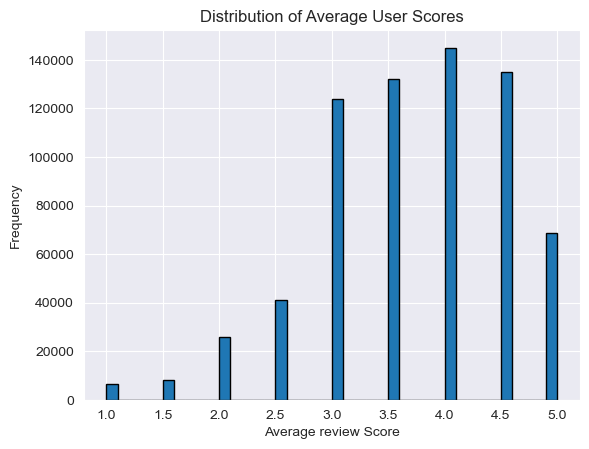

In [668]:
plt.hist(df2['review_overall'], bins=40, edgecolor='black')

# Adicione rótulos e título ao gráfico
plt.xlabel('Average review Score')
plt.ylabel('Frequency')
plt.title('Distribution of Average User Scores')

In [669]:
reader = Reader()
ratings = df2[['review_profilename', 'beer_beerid', 'review_overall']]
ratings

,review_profilename,beer_beerid,review_overall
0,JamnesCameron,36862,2.5
1,jsh420,36862,2.0
2,GatorBeerNerd,36862,2.5
3,AltBock,36862,2.5
4,bluejacket74,36862,2.5
...,...,...,...
686655,rajendra82,16487,5.0
686656,DaPeculierDane,16487,5.0
686657,Bobikel,16487,5.0
686658,marburg,16487,5.0


In [670]:
data = Dataset.load_from_df(ratings[['review_profilename', 'beer_beerid', 'review_overall']], reader)

svd = SVD()
kf = KFold(n_splits=5)
kf.split(data)
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([0.69192685, 0.6951123 , 0.69280815, 0.69022577, 0.6959628 ]),
 'test_mae': array([0.53741144, 0.53956858, 0.53889816, 0.53666725, 0.53956196]),
 'fit_time': (25.068726301193237,
  25.627520084381104,
  26.0719952583313,
  25.006978511810303,
  24.70215082168579),
 'test_time': (0.7599999904632568,
  0.7559993267059326,
  0.8380069732666016,
  0.7840189933776855,
  0.7699873447418213)}

In [671]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [672]:
df2

,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid,mean ibu,avg_user_score
0,2.5,4.5,2.5,JamnesCameron,Hefeweizen,2.5,2.5,Wild Frog Wheat Ale,6.0,36862,12.5,3.968675
1,2.0,2.0,2.0,jsh420,Hefeweizen,2.0,2.0,Wild Frog Wheat Ale,6.0,36862,12.5,3.678862
2,2.5,4.0,3.5,GatorBeerNerd,Hefeweizen,3.0,3.5,Wild Frog Wheat Ale,6.0,36862,12.5,3.984914
3,2.5,3.5,3.5,AltBock,Hefeweizen,2.5,3.0,Wild Frog Wheat Ale,6.0,36862,12.5,3.635234
4,2.5,3.0,3.0,bluejacket74,Hefeweizen,3.5,2.5,Wild Frog Wheat Ale,6.0,36862,12.5,3.874805
...,...,...,...,...,...,...,...,...,...,...,...,...
686655,5.0,4.0,4.5,rajendra82,Bière de Champagne / Bière Brut,4.5,4.0,Malheur Brut Noir (Black Chocolate),12.0,16487,40.0,4.000665
686656,5.0,4.0,4.5,DaPeculierDane,Bière de Champagne / Bière Brut,5.0,4.5,Malheur Brut Noir (Black Chocolate),12.0,16487,40.0,3.831050
686657,5.0,4.0,4.0,Bobikel,Bière de Champagne / Bière Brut,4.0,3.5,Malheur Brut Noir (Black Chocolate),12.0,16487,40.0,3.993590
686658,5.0,4.5,5.0,marburg,Bière de Champagne / Bière Brut,4.5,4.5,Malheur Brut Noir (Black Chocolate),12.0,16487,40.0,4.111324


In [673]:
ratings[ratings['review_profilename'] == 'JamnesCameron']

,review_profilename,beer_beerid,review_overall
0,JamnesCameron,36862,2.5
1882,JamnesCameron,2653,2.5
2444,JamnesCameron,17538,1.5
2856,JamnesCameron,34085,2.0
3749,JamnesCameron,61128,1.5
...,...,...,...
684203,JamnesCameron,6354,5.0
685803,JamnesCameron,49092,5.0
686504,JamnesCameron,2595,5.0
686563,JamnesCameron,10683,5.0


In [674]:
svd.predict('Strix', 64228)

Prediction(uid='Strix', iid=64228, r_ui=None, est=4.875779267185257, details={'was_impossible': False})

In [675]:
#beers_id = df['beer_beerid']

In [703]:
def recomendar(user):
    df3 = df.loc[df['review_profilename'] == user]
    beers_id = list(df3['beer_beerid'])
    notas = []
    cervejas = []

    for b in beers_id:
        pred = svd.predict(user, b)
        nota = pred.est
        cerveja_id = pred.iid
        notas.append(nota)
        cervejas.append(cerveja_id)

    indice_max_nota = notas.index(max(notas))
    cerveja_recomendada = cervejas[indice_max_nota]

    return cerveja_recomendada

In [704]:
print(recomendar('JamnesCameron'))

62397


Uau, no nosso primeiro teste tivemos como recomendação uma cerveja que o usuário avaliou como 5

vamos agora ver o quão distante nossas recomendações estão da nota máxima que um usuário deu

In [690]:
users = df['review_profilename'].unique()
#users = users.sample(n= 1200, random_state=42)

In [691]:
err = []
for u in users:
    cr = recomendar(u)
    nmax = df[df['review_profilename'] == u]['review_overall'].max()
    nd = df[(df['review_profilename'] == u) & (df['beer_beerid'] == cr)]['review_overall'].values

    if len(nd) > 0:  # Verifique se há valores em nd antes de calcular o erro
        error = abs(nmax - nd[0])  # Use nd[0] para obter o valor único
        err.append(error)

    print(u, cr)

# Calcule o erro médio apenas se houver erros na lista err
if err:
    average_error = sum(err) / len(err)
    print('ERRO MÉDIO:', average_error)
else:
    print('Nenhum erro calculado.')


Vancer 731
Grundle20 731
mattsdenney 46363
IPAcraig 857
marcpal 17112
swhitt 1160
carln26 507
beernut7 507
davidchollar 731
Naerhu 3327
martymoat 1621
Mitchster 17910
shapudding 2093
NeroFiddled 1256
Risser09 1062
WVbeergeek 26384
DarkerTheBetter 6368
Gavage 48434
kaseydad 29619
Gosox8787 16814
MisterClean 35015
mothman 64228
Northsider 48434
willjschmidt 7971
DearthVader 58610
TheGordianKnot 47658
Miketwolf21 48434
GoldenChild 19960
DannyDan 48434
jsanford 7971
tbrown4 48434
Andrewtherooster 48434
ktrillionaire 37586
JizackFH 47658
brandoncox 21822
micromaniac129 48434
DovaliHops 7971
NODAK 48434
bohemiandonut 29619
dcook11 695
4000qtrap 21690
Soonami 64228
aggiearcher13 7971
Freethyhops 695
AgentMunky 1545
digitalbullet 695
Axic10 56082
JK4Stout 48434
brewdoc75 7971
HeroicDoses 48434
spicelab 48434
Evocatus 731
ThePortlander 48434
bump8628 7971
Sam21 48434
cnally 731
kegger22 48434
chickenflea 48434
Gyle41386 21690
generalnotsew 29127
Heavenisbeer 48434
WeisGuy 58610
PhillyStyle 7971

KeyboardInterrupt: 

In [707]:
ratings[ratings['review_profilename'] == 'JamnesCameron']

,review_profilename,beer_beerid,review_overall
0,JamnesCameron,36862,2.5
1882,JamnesCameron,2653,2.5
2444,JamnesCameron,17538,1.5
2856,JamnesCameron,34085,2.0
3749,JamnesCameron,61128,1.5
...,...,...,...
684203,JamnesCameron,6354,5.0
685803,JamnesCameron,49092,5.0
686504,JamnesCameron,2595,5.0
686563,JamnesCameron,10683,5.0


In [693]:
svd.predict('Strix', 1336)

Prediction(uid='Strix', iid=1336, r_ui=None, est=3.8240614573447766, details={'was_impossible': False})

In [706]:
print(recomendar('eballard'))

ValueError: max() arg is an empty sequence